In [2]:
import pandas as pd
import numpy as np

In [3]:
# csv 불러오기
funding_rounds = pd.read_csv('/Users/jb/Documents/DSL/crunchbase_1/funding_rounds.csv')
investments = pd.read_csv('/Users/jb/Documents/DSL/crunchbase_2/investments.csv')
organizations = pd.read_csv('/Users/jb/Documents/DSL/crunchbase_4/organizations.csv')

In [4]:
# 모든 column 보기
pd.set_option('display.max_columns', None)

In [16]:
# angel round 받은 금액
angel_amount = funding_rounds[funding_rounds['investment_type'] == 'angel'][['org_uuid', 'raised_amount_usd']].dropna(axis=0)
angel_amount.columns = ['org_uuid', 'angel_amount']
angel_amount = angel_amount.groupby('org_uuid').sum()
angel_amount.reset_index(level=['org_uuid'], inplace=True)

In [18]:
# seed round 받은 금액
seed_amount = funding_rounds[funding_rounds['investment_type'] == 'seed'][['org_uuid', 'raised_amount_usd']].dropna(axis=0)
seed_amount.columns = ['org_uuid', 'seed_amount']
seed_amount = seed_amount.groupby('org_uuid').sum()
seed_amount.reset_index(level=['org_uuid'], inplace=True)

In [19]:
# pre_seed round 받은 금액
pre_seed_amount = funding_rounds[funding_rounds['investment_type'] == 'pre_seed'][['org_uuid', 'raised_amount_usd']].dropna(axis=0)
pre_seed_amount.columns = ['org_uuid', 'pre_seed_amount']
pre_seed_amount = pre_seed_amount.groupby('org_uuid').sum()
pre_seed_amount.reset_index(level=['org_uuid'], inplace=True)

In [44]:
# seed dataframe 만들기
seed = pd.DataFrame(funding_rounds['org_uuid'].unique(), columns=['org_uuid'])
seed = pd.merge(seed, angel_amount, how='left', on='org_uuid')
seed = pd.merge(seed, seed_amount, how='left', on='org_uuid')
seed = pd.merge(seed, pre_seed_amount, how='left', on='org_uuid')
seed = seed.fillna(0)

In [45]:
# 초기 자금 열 만들기
seed['seed'] = seed['angel_amount'] + seed['seed_amount'] + seed['pre_seed_amount']

In [46]:
# Series A 투자를 받았는지 여부 열 만들기
series_a = pd.DataFrame(funding_rounds[funding_rounds['investment_type'] == 'series_a']['org_uuid'].unique(), columns=['org_uuid'])
series_a['is_series_a'] = 1
seed = pd.merge(seed, series_a, how='left', on='org_uuid')
seed['is_series_a'] = seed['is_series_a'].fillna(0)

In [47]:
seed.groupby('is_series_a').mean()['seed']

is_series_a
0.0    5.808603e+05
1.0    1.003462e+06
Name: seed, dtype: float64

In [48]:
yes_a = seed[seed['is_series_a'] == 1]

In [49]:
no_a = seed[seed['is_series_a'] == 0]

In [50]:
yes_a.loc[yes_a[yes_a['seed'] == 0].index, 'seed'] = seed.groupby('is_series_a').mean()['seed'][1]

In [51]:
no_a.loc[no_a[no_a['seed'] == 0].index, 'seed'] = seed.groupby('is_series_a').mean()['seed'][0]

In [52]:
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

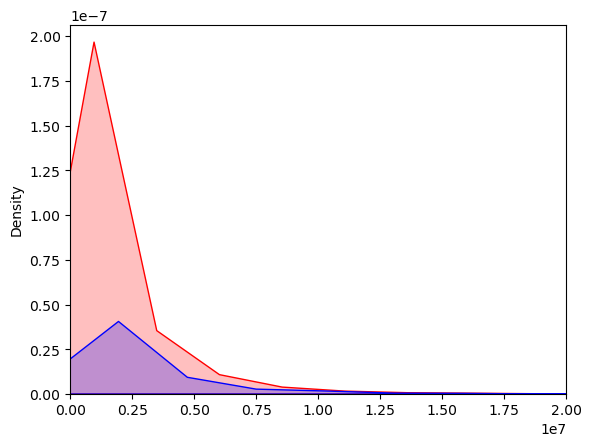

In [53]:
# 정규성 검정
series_a_amount = seed[seed['is_series_a'] == 1]['seed'].values.tolist()
no_series_a_amount = seed[seed['is_series_a'] == 0]['seed'].values.tolist()

sns.kdeplot(data=series_a_amount, color='red', shade=True)
sns.kdeplot(data=no_series_a_amount, color='blue', shade=True)
plt.xlim([0, 2e+7])
plt.show()

In [54]:
# 등분산 검정
print(stats.levene(series_a_amount, no_series_a_amount))

LeveneResult(statistic=577.7893630964514, pvalue=1.560756126537672e-127)


In [55]:
# t-test
t_stat, p_value = stats.ttest_ind(series_a_amount, no_series_a_amount, equal_var=True, alternative="two-sided")
print("t-statistics : {}, p-value : {}".format(t_stat, p_value))

t-statistics : 24.037249491080534, p-value : 1.560756126239156e-127


In [ ]:
# series a 투자 유치 여부에 따라 구분한 그룹의 초기 투자 자본금 평균이 유의미하게 차이남

In [56]:
# 시각화 라이브러리 불러오기
import matplotlib.pyplot as plt
import seaborn as sns

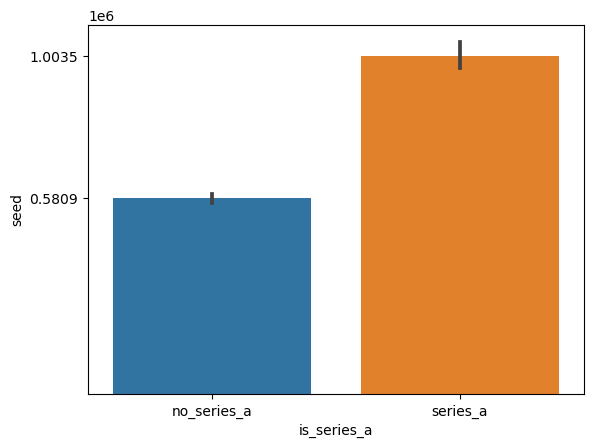

In [60]:
# barplot을 활용하여 시각화

sns.barplot(data = seed, x = 'is_series_a', y = 'seed', estimator = np.mean)
plt.xticks([0, 1], ['no_series_a', 'series_a'])
plt.yticks(seed.groupby('is_series_a').seed.mean())
plt.show()

In [ ]:
# 이야기의 flow가 series a 유치에는 초기 자금 factor가 영향이 크다, but 장기적인 관점에서는 딱히 의미 없다

In [ ]:
# future success를 series a 유치라고 보자
# 근거에 대해서는 더 고민해봐야할 듯
# 투자사들의 궁극적인 목적은 투자금 회수!, 우리가 주목해야하는 것은 IPO와 M&A

In [ ]:
# M&A와 ipo 여부 칼럼 추가
by_series

,uuid,is_angel,is_series_a,is_series_b,is_seed,is_series_c,is_series_d,is_series_unknown,is_debt_financing,is_series_e,is_private_equity,is_series_f,is_pre_seed,is_undisclosed,is_grant,is_post_ipo_equity,is_convertible_note,is_post_ipo_debt,is_non_equity_assistance,is_corporate_round,is_series_i,is_series_g,is_secondary_market,is_post_ipo_secondary,is_initial_coin_offering,is_series_h,is_product_crowdfunding,is_equity_crowdfunding,is_series_j
0,df662812-7f97-0b43-9d3e-12f64f504fbb,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,f53cb4de-236e-0b1b-dee8-7104a8b018f9,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4111dc8b-c0df-2d24-ed33-30cd137b3098,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3d16cb4c-911e-75c0-de5a-15c316b39f98,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,56b5f0c1-855f-2ebb-083f-16641f1db2e1,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262424,974435e5-3d55-4392-b37f-7d97720c7593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262425,594796d0-0bb6-4e58-946e-58785eb81e9a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262426,67d03bbd-e144-4ea5-9071-fc2afdd8f905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262427,37cd0e99-978e-4481-b018-a7dffa69d6f8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
acquisitions = pd.read_csv('/Users/jb/Documents/DSL/crunchbase_1/acquisitions.csv')
ipos = pd.read_csv('/Users/jb/Documents/DSL/crunchbase_2/ipos.csv')

In [ ]:
acquisitions['acquiree_uuid'].unique()

array(['180ebf67-68d0-2316-e93d-8e1e546330ba',
       '5b05e013-a448-3a0b-d872-a6ae668e1192',
       '8249dffa-1ca6-6f99-9f76-d56c83f85f2d', ...,
       'c5cd1e6f-43df-8cb5-6ae1-f0fbe4eec600',
       '8901862b-2fa1-4f74-8858-e2c1902503e7',
       'b1860f3f-4865-48e1-9760-172b79a4a97c'], dtype=object)

In [ ]:
by_acquisitions = pd.DataFrame(funding_rounds['org_uuid'].unique(), columns=['org_uuid'])

In [ ]:
is_acquisitions = pd.DataFrame(acquisitions['acquiree_uuid'].unique(), columns=['org_uuid'])

In [ ]:
is_acquisitions['is_acquisitions'] = 1

In [ ]:
by_acquisitions = pd.merge(by_acquisitions, is_acquisitions, how='left', on='org_uuid')

In [ ]:
by_acquisitions = by_acquisitions.fillna(0)

In [ ]:
is_ipos = pd.DataFrame(ipos['org_uuid'].unique(), columns=['org_uuid'])

In [ ]:
is_ipos['is_ipos'] = 1

In [ ]:
by_success = pd.merge(by_acquisitions, is_ipos, how='left', on='org_uuid')

In [ ]:
by_success = by_success.fillna(0)

In [ ]:
by_success

,org_uuid,is_acquisitions,is_ipos
0,df662812-7f97-0b43-9d3e-12f64f504fbb,0.0,1.0
1,f53cb4de-236e-0b1b-dee8-7104a8b018f9,1.0,0.0
2,4111dc8b-c0df-2d24-ed33-30cd137b3098,1.0,0.0
3,3d16cb4c-911e-75c0-de5a-15c316b39f98,1.0,0.0
4,56b5f0c1-855f-2ebb-083f-16641f1db2e1,1.0,0.0
...,...,...,...
262424,974435e5-3d55-4392-b37f-7d97720c7593,0.0,0.0
262425,594796d0-0bb6-4e58-946e-58785eb81e9a,0.0,0.0
262426,67d03bbd-e144-4ea5-9071-fc2afdd8f905,0.0,0.0
262427,37cd0e99-978e-4481-b018-a7dffa69d6f8,0.0,0.0


In [ ]:
by_success.to_csv('by_success.csv')

In [ ]:
by_success = pd.merge(by_success, angel_amount, how='left', on='org_uuid')
by_success = pd.merge(by_success, seed_amount, how='left', on='org_uuid')
by_success = pd.merge(by_success, pre_seed_amount, how='left', on='org_uuid')

In [ ]:
by_success = by_success.fillna(0)

In [ ]:
by_success['seed'] = by_success['angel_amount'] + by_success['seed_amount'] + by_success['pre_seed_amount']

In [ ]:
by_success['is_success'] = by_success['is_acquisitions'] + by_success['is_ipos']

In [ ]:
by_success['is_success'] = by_success['is_success'].apply(lambda x : int(bool(x)))

In [ ]:
temp = by_success.drop(by_success[by_success['seed'] == 0].index, inplace=False)

In [ ]:
temp.groupby('is_success').seed.mean()

is_success
0    1.710817e+06
1    1.731399e+06
Name: seed, dtype: float64

In [ ]:
success = by_success[by_success['is_success'] == 1]

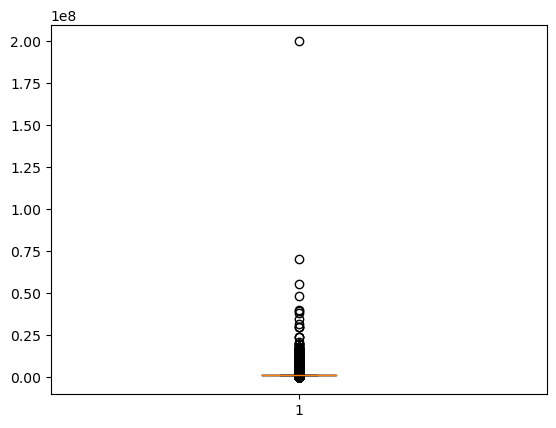

In [ ]:
plt.boxplot(success)
plt.show()

In [ ]:
fail = by_success[by_success['is_success'] == 0]

In [ ]:
success.loc[success[success['seed'] == 0].index, 'seed'] = temp.groupby('is_success').seed.mean()[1]

In [ ]:
fail.loc[fail[fail['seed'] == 0].index, 'seed'] = temp.groupby('is_success').seed.mean()[0]

In [ ]:
by_success = pd.concat([success, fail])

In [ ]:
by_success['is_success'].value_counts()

0    222729
1     39700
Name: is_success, dtype: int64

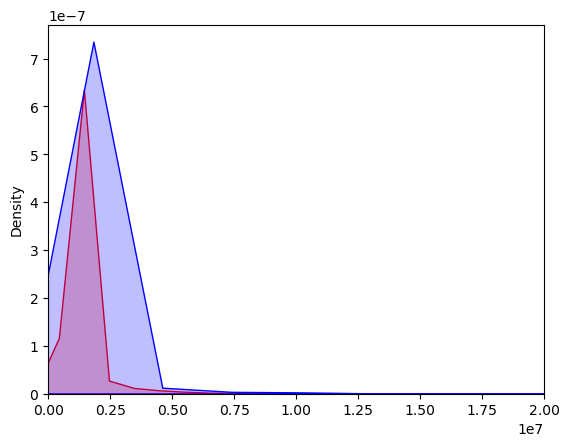

In [ ]:
success = by_success[by_success['is_success'] == 1]['seed'].values.tolist()
fail = by_success[by_success['is_success'] == 0]['seed'].values.tolist()

sns.kdeplot(data=success, color='red', shade=True)
sns.kdeplot(data=fail, color='blue', shade=True)
plt.xlim([0, 2e+7])
plt.show()

In [ ]:
print(stats.levene(success, fail))

LeveneResult(statistic=545.0539166716899, pvalue=1.9914312562764294e-120)


In [ ]:
t_stat, p_value = stats.ttest_ind(success, fail, equal_var=True, alternative="two-sided")
print("t-statistics : {}, p-value : {}".format(t_stat, p_value))

t-statistics : 1.1065852028002503, p-value : 0.26847432214628414


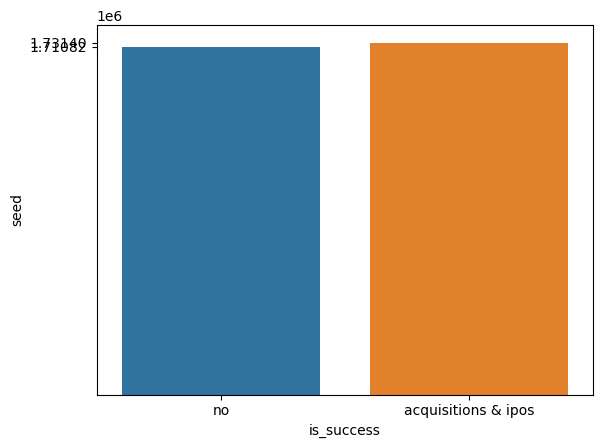

In [ ]:
sns.barplot(data = by_success, x = 'is_success', y = 'seed', estimator = np.median)
plt.xticks([0, 1], ['no', 'acquisitions & ipos'])
plt.yticks(by_success.groupby('is_success').seed.median())
plt.show()

In [13]:
people = pd.read_csv('/Users/jb/Documents/DSL/crunchbase_3/people.csv')

In [38]:
people = people.drop(people[people['featured_job_title'].isnull()].index)

In [40]:
co_founder1 = people[people['featured_job_title'].str.contains('Co-Founder')]

In [42]:
co_founder2 = people[people['featured_job_title'].str.contains('co-Founder')]

In [44]:
co_founder3 = people[people['featured_job_title'].str.contains('co-founder')]

In [46]:
co_founder4 = people[people['featured_job_title'].str.contains('Co-founder')]

In [48]:
co_founder5 = people[people['featured_job_title'].str.contains('cofounder')]

In [50]:
co_founder6 = people[people['featured_job_title'].str.contains('co founder')]

In [52]:
co_founder = pd.concat([co_founder1, co_founder2, co_founder3, co_founder4, co_founder5, co_founder6])

In [53]:
co_founder

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,first_name,last_name,gender,country_code,state_code,region,city,featured_job_organization_uuid,featured_job_organization_name,featured_job_title,facebook_url,linkedin_url,twitter_url,logo_url
0,ed13cd36-fe2b-3707-197b-0c2d56e37a71,Ben Elowitz,person,ben-elowitz,https://www.crunchbase.com/person/ben-elowitz,28064.0,2007-05-25 14:03:54,2022-06-27 08:59:09,Ben,Elowitz,male,USA,WA,Washington,Seattle,1d845b32-7d80-47af-957d-78ccbeeaefb6,Zeitworks,Co-Founder,http://www.facebook.com/elowitz,https://www.linkedin.com/in/elowitz,http://twitter.com/elowitz,https://res.cloudinary.com/crunchbase-producti...
5,80d25c23-9726-9dda-5852-39cdf4810ea5,Ron Gorodetzky,person,ron-gorodetzky,https://www.crunchbase.com/person/ron-gorodetzky,333441.0,2007-05-26 03:07:50,2021-02-08 10:38:18,Ron,Gorodetzky,male,NaN,NaN,NaN,NaN,aa3bf156-06af-5b6e-215d-9e7211fc173b,Fflick,Co-Founder and CTO,NaN,NaN,NaN,https://res.cloudinary.com/crunchbase-producti...
7,084aaa07-0795-1fe8-9c46-98bbeb02cd64,Dustin Moskovitz,person,dustin-moskovitz,https://www.crunchbase.com/person/dustin-mosko...,2275.0,2007-05-26 05:15:05,2019-06-07 20:29:51,Dustin,Moskovitz,male,USA,CA,California,San Francisco,c2d47d05-9e78-de77-084c-dd5171251ff1,Asana,CEO & Co-Founder,http://www.facebook.com/moskov,https://www.linkedin.com/in/dmoskov,http://twitter.com/moskov,https://res.cloudinary.com/crunchbase-producti...
16,f7e8c40f-c146-cf63-65f2-9e292c0d2323,Peter Pham,person,peter-pham,https://www.crunchbase.com/person/peter-pham,1331.0,2007-05-26 19:49:45,2022-01-18 01:57:31,Peter,Pham,male,USA,CA,California,Manhattan Beach,f1ebf335-96d6-edaf-0b45-55ce87fd1891,Science,Co-Founder & Managing Director,http://www.facebook.com/peterpham1,http://www.linkedin.com/in/peterpham,http://twitter.com/peterpham,https://res.cloudinary.com/crunchbase-producti...
21,b0e4e511-a1f1-162d-005a-006a94ee35f6,David O. Sacks,person,david-sacks,https://www.crunchbase.com/person/david-sacks,191.0,2007-06-01 02:56:06,2022-08-18 01:06:06,David O.,Sacks,male,USA,CA,California,San Francisco,904a716a-93d3-4456-9543-70fcf381e268,Craft Ventures,Co-Founder & Partner,NaN,https://www.linkedin.com/in/davidoliversacks,https://twitter.com/DavidSacks,https://res.cloudinary.com/crunchbase-producti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153876,244eae48-5009-43c1-b045-2778e0ca35ad,Sree raj,person,sree-raj-35ad,https://www.crunchbase.com/person/sree-raj-35ad,668825.0,2021-07-06 11:20:08,2022-04-16 06:25:30,Sree,raj,male,USA,CA,California,San Francisco,8ff0ead2-6465-4309-87f0-7ea9b3d758e1,FieldNXT,Director & co founder,NaN,https://www.linkedin.com/in/sreerajtn/,NaN,NaN
1175024,be025a7a-f19f-4a65-9069-ab35ba5ab6ac,Justin Fang,person,justin-fang-b6ac,https://www.crunchbase.com/person/justin-fang-...,327844.0,2021-08-11 19:33:26,2022-04-22 08:53:13,Justin,Fang,male,KEN,NaN,Nairobi Area,Nairobi,1eab4499-28ea-47ac-8fa3-5a23e8dabad0,Modern Products,co founder,NaN,https://www.linkedin.com/in/justin-fang-4162b8...,NaN,https://res.cloudinary.com/crunchbase-producti...
1339250,162dc94e-4ac7-4012-80d6-7ee0520731e3,Emre Güzeldal,person,emre-güzeldal,https://www.crunchbase.com/person/emre-güzeldal,259987.0,2022-02-21 07:11:37,2022-04-19 15:25:04,Emre,Güzeldal,male,TUR,NaN,Istanbul,Istanbul,0916ab7e-b4dc-4a3d-a84f-1ec9bef67903,Roketfy,CEO and co founder,NaN,https://www.linkedin.com/in/emreguzeldal/,https://twitter.com/emreguzeldal,https://res.cloudinary.com/crunchbase-producti...
1364651,b9319f1c-ed00-4e74-825e-113e3ce20251,Cadu Cerizze,person,cadu-cerizze,https://www.crunchbase.com/person/cadu-cerizze,86000.0,2022-03-18 20:59:47,2022-04-02 09:44:33,Cadu,Cerizze,male,BRA,NaN,Rio de Janeiro,Rio De Janeiro,50762456-079d-4ff7-bf74-f0a2eda7e4a6,Vesper Club,co founder,NaN,https://www.linkedin.com/in/caducerizze/,NaN,https://res.cloudinary.com/crunchbase-producti...


In [25]:
degrees = pd.read_csv('/Users/jb/Documents/DSL/crunchbase_1/degrees.csv')

**여기가 카테고리 분류의 현장입니다** 

In [66]:
organizations

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,legal_name,roles,domain,homepage_url,country_code,state_code,region,city,address,postal_code,status,short_description,category_list,category_groups_list,num_funding_rounds,total_funding_usd,total_funding,total_funding_currency_code,founded_on,last_funding_on,closed_on,employee_count,email,phone,facebook_url,linkedin_url,twitter_url,logo_url,alias1,alias2,alias3,primary_role,num_exits
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,wetpaint,https://www.crunchbase.com/organization/wetpaint,199033.0,2007-05-25 13:51:27,2022-03-07 05:47:35,NaN,company,wetpaint.com,http://www.wetpaint.com/,USA,NY,New York,New York,902 Broadway 11th Floor New,10010,acquired,Wetpaint offers an online social publishing pl...,"Publishing,Social Media,Social Media Management","Content and Publishing,Internet Services,Media...",3.0,3.975000e+07,3.975000e+07,USD,2005-06-01,2008-05-19,NaN,51-100,info@wetpaint.com,206-859-6300,https://www.facebook.com/Wetpaint,NaN,https://twitter.com/wetpainttv,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN
1,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,zoho,https://www.crunchbase.com/organization/zoho,80721.0,2007-05-26 02:30:28,2022-09-28 04:34:33,Zoho Corporation Pvt. Ltd.,"investor,company",zoho.com,https://www.zoho.com,USA,CA,California,Pleasanton,NaN,NaN,operating,"Zoho offers a suite of business, collaboration...","Cloud Computing,Collaboration,Developer Tools,...","Administrative Services,Apps,Information Techn...",NaN,NaN,NaN,NaN,1996-03-17,NaN,NaN,10000+,sales@zohocorp.com,044 - 67447070,http://www.facebook.com/zoho,https://www.linkedin.com/company/zoho,http://twitter.com/zoho,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,2.0
2,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,organization,digg,https://www.crunchbase.com/organization/digg,21681.0,2007-05-26 03:03:23,2018-12-10 10:09:14,"Digg Holdings, LLC",company,digg.com,http://www.digg.com,USA,NY,New York,New York,NaN,NaN,acquired,Digg Inc. operates a website that enables its ...,"Internet,Social Media,Social Network","Internet Services,Media and Entertainment",6.0,4.900000e+07,4.900000e+07,USD,2004-10-11,2016-09-13,NaN,51-100,feedback@digg.com,877-342-7222,http://www.facebook.com/digg,http://www.linkedin.com/company/digg,http://twitter.com/digg,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN
3,f4d5ab44-058b-298b-ea81-380e6e9a8eec,Omidyar Network,organization,omidyar-network,https://www.crunchbase.com/organization/omidya...,211432.0,2007-05-26 03:21:34,2022-07-19 01:45:23,NaN,"investor,company",omidyar.com,http://www.omidyar.com,USA,CA,California,Redwood City,1991 Broadway Suite 200,94063,operating,Omidyar Network is an investment firm.,"Enterprise Software,Financial Services,Venture...","Financial Services,Lending and Investments,Sof...",NaN,NaN,NaN,NaN,2004-01-01,NaN,NaN,101-250,info@omidyar.com,650.482.2500,http://www.facebook.com/OmidyarNetwork,http://www.linkedin.com/company/22806,http://twitter.com/OmidyarNetwork,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,investor,54.0
4,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,organization,facebook,https://www.crunchbase.com/organization/facebook,5.0,2007-05-26 04:22:15,2022-08-05 13:19:05,"Meta Platforms, Inc.","investor,company",meta.com,https://meta.com,USA,CA,California,Menlo Park,1 Hacker Way,94025,ipo,Meta is a social technology company that enabl...,"Augmented Reality,Social Media,Social Network,...","Hardware,Internet Services,Media and Entertain...",17.0,2.612282e+10,2.612282e+10,USD,2004-02-04,2022-08-04,NaN,10000+,NaN,NaN,https://www.facebook.com/Meta,https://www.linkedin.com/company/meta,https://twitter.com/Meta,https://res.cloudinary.com/crunchbase-producti...,Facebook,"Facebook, Inc.",NaN,company,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [61]:
with_degree = pd.merge(co_founder, degrees[['person_uuid', 'institution_name']], how='left', left_on='uuid', right_on='person_uuid')

In [62]:
with_degree

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,first_name,last_name,gender,country_code,state_code,region,city,featured_job_organization_uuid,featured_job_organization_name,featured_job_title,facebook_url,linkedin_url,twitter_url,logo_url,person_uuid,institution_name
0,ed13cd36-fe2b-3707-197b-0c2d56e37a71,Ben Elowitz,person,ben-elowitz,https://www.crunchbase.com/person/ben-elowitz,28064.0,2007-05-25 14:03:54,2022-06-27 08:59:09,Ben,Elowitz,male,USA,WA,Washington,Seattle,1d845b32-7d80-47af-957d-78ccbeeaefb6,Zeitworks,Co-Founder,http://www.facebook.com/elowitz,https://www.linkedin.com/in/elowitz,http://twitter.com/elowitz,https://res.cloudinary.com/crunchbase-producti...,ed13cd36-fe2b-3707-197b-0c2d56e37a71,University of California Berkeley
1,ed13cd36-fe2b-3707-197b-0c2d56e37a71,Ben Elowitz,person,ben-elowitz,https://www.crunchbase.com/person/ben-elowitz,28064.0,2007-05-25 14:03:54,2022-06-27 08:59:09,Ben,Elowitz,male,USA,WA,Washington,Seattle,1d845b32-7d80-47af-957d-78ccbeeaefb6,Zeitworks,Co-Founder,http://www.facebook.com/elowitz,https://www.linkedin.com/in/elowitz,http://twitter.com/elowitz,https://res.cloudinary.com/crunchbase-producti...,ed13cd36-fe2b-3707-197b-0c2d56e37a71,University of California Berkeley
2,80d25c23-9726-9dda-5852-39cdf4810ea5,Ron Gorodetzky,person,ron-gorodetzky,https://www.crunchbase.com/person/ron-gorodetzky,333441.0,2007-05-26 03:07:50,2021-02-08 10:38:18,Ron,Gorodetzky,male,NaN,NaN,NaN,NaN,aa3bf156-06af-5b6e-215d-9e7211fc173b,Fflick,Co-Founder and CTO,NaN,NaN,NaN,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN
3,084aaa07-0795-1fe8-9c46-98bbeb02cd64,Dustin Moskovitz,person,dustin-moskovitz,https://www.crunchbase.com/person/dustin-mosko...,2275.0,2007-05-26 05:15:05,2019-06-07 20:29:51,Dustin,Moskovitz,male,USA,CA,California,San Francisco,c2d47d05-9e78-de77-084c-dd5171251ff1,Asana,CEO & Co-Founder,http://www.facebook.com/moskov,https://www.linkedin.com/in/dmoskov,http://twitter.com/moskov,https://res.cloudinary.com/crunchbase-producti...,084aaa07-0795-1fe8-9c46-98bbeb02cd64,Harvard University
4,f7e8c40f-c146-cf63-65f2-9e292c0d2323,Peter Pham,person,peter-pham,https://www.crunchbase.com/person/peter-pham,1331.0,2007-05-26 19:49:45,2022-01-18 01:57:31,Peter,Pham,male,USA,CA,California,Manhattan Beach,f1ebf335-96d6-edaf-0b45-55ce87fd1891,Science,Co-Founder & Managing Director,http://www.facebook.com/peterpham1,http://www.linkedin.com/in/peterpham,http://twitter.com/peterpham,https://res.cloudinary.com/crunchbase-producti...,f7e8c40f-c146-cf63-65f2-9e292c0d2323,"University of California, Irvine"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179510,162dc94e-4ac7-4012-80d6-7ee0520731e3,Emre Güzeldal,person,emre-güzeldal,https://www.crunchbase.com/person/emre-güzeldal,259987.0,2022-02-21 07:11:37,2022-04-19 15:25:04,Emre,Güzeldal,male,TUR,NaN,Istanbul,Istanbul,0916ab7e-b4dc-4a3d-a84f-1ec9bef67903,Roketfy,CEO and co founder,NaN,https://www.linkedin.com/in/emreguzeldal/,https://twitter.com/emreguzeldal,https://res.cloudinary.com/crunchbase-producti...,162dc94e-4ac7-4012-80d6-7ee0520731e3,Uludağ University
179511,b9319f1c-ed00-4e74-825e-113e3ce20251,Cadu Cerizze,person,cadu-cerizze,https://www.crunchbase.com/person/cadu-cerizze,86000.0,2022-03-18 20:59:47,2022-04-02 09:44:33,Cadu,Cerizze,male,BRA,NaN,Rio de Janeiro,Rio De Janeiro,50762456-079d-4ff7-bf74-f0a2eda7e4a6,Vesper Club,co founder,NaN,https://www.linkedin.com/in/caducerizze/,NaN,https://res.cloudinary.com/crunchbase-producti...,b9319f1c-ed00-4e74-825e-113e3ce20251,Federal University of Rio de Janeiro
179512,b9319f1c-ed00-4e74-825e-113e3ce20251,Cadu Cerizze,person,cadu-cerizze,https://www.crunchbase.com/person/cadu-cerizze,86000.0,2022-03-18 20:59:47,2022-04-02 09:44:33,Cadu,Cerizze,male,BRA,NaN,Rio de Janeiro,Rio De Janeiro,50762456-079d-4ff7-bf74-f0a2eda7e4a6,Vesper Club,co founder,NaN,https://www.linkedin.com/in/caducerizze/,NaN,https://res.cloudinary.com/crunchbase-producti..

In [87]:
category[category['category_groups_list'] == 'Content and Publishing']

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,category_groups_list
155,b9cab5d0-2afc-6b49-ff6d-796d2ab49334,Content Delivery Network,category,content-delivery-network,https://www.crunchbase.com/category/content-de...,NaN,2014-04-20 07:58:47,2018-02-13 00:59:11,Content and Publishing


In [85]:
trim_org = organizations.drop(organizations[organizations['category_groups_list'].isnull()].index)

In [88]:
trim_org['category_groups_list'] = trim_org['category_groups_list'].apply(lambda x: x.split(','))

In [97]:
trim_org.shape

(2248787, 41)

In [113]:
trim_org['category_groups_list']

0          [Content and Publishing, Internet Services, Me...
1          [Administrative Services, Apps, Information Te...
2               [Internet Services, Media and Entertainment]
3          [Financial Services, Lending and Investments, ...
4          [Hardware, Internet Services, Media and Entert...
                                 ...                        
2416734    [Commerce and Shopping, Health Care, Mobile, S...
2416735         [Commerce and Shopping, Sales and Marketing]
2416736                                        [Health Care]
2416737                    [Professional Services, Software]
2416738                [Financial Services, Other, Software]
Name: category_groups_list, Length: 2248787, dtype: object

In [118]:
cat_dict = {}

for cat in cat_list:
    a = 0
    for i in range(2416739):
        try:
            a = a + int(cat in trim_org['category_groups_list'][i])
        except:
            pass
    cat_dict[cat] = a



    # 차라리 카테고리별 columns을 만들어서 1, 0 으로 이진 분류 하는게 낫지 않을까요????????????????????

In [91]:
cat_list = list(category['category_groups_list'].unique())